In [25]:
import pandas as pd
import cdt
import pickle
import networkx as nx
import matplotlib.pyplot as plt

In [26]:
# read data
df = pd.read_csv('../../data/session-df-ak.csv')
#df = pd.read_csv('../../data/training_set/log_mini.csv')
#df = pickle.load( open( "../../data/df_causal_discovery.p", "rb") )

In [27]:
df.columns

Index(['Unnamed: 0', 'session_id', 'session_position', 'session_length',
       'track_id_clean', 'skip_1', 'skip_2', 'skip_3', 'not_skipped',
       'context_switch', 'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'skip', 'custom_skip', 'pause_before_play', 'custom_pause_before_play'],
      dtype='object')

In [28]:
cols1 = ['custom_skip', 'hour_of_day', 'session_position', 'premium', 'session_length', 'no_pause_before_play']
df1 = df[cols1]
for col in cols1:
    df1[col] = df1[col].astype(int)

cols2 = ['custom_skip', 'hour_of_day', 'session_position', 'premium', 'no_pause_before_play']
df2 = df[cols2]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


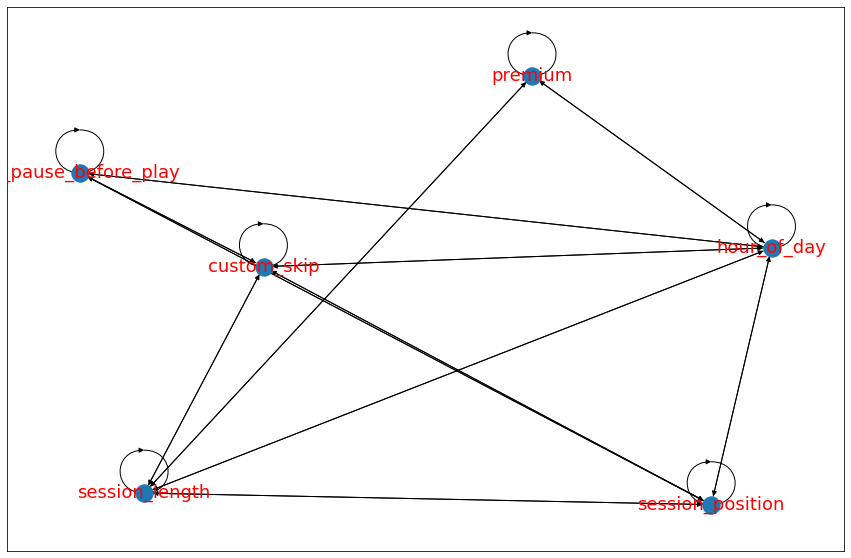

In [29]:
# Get skeleton graph
# initialize graph lasso
glasso = cdt.independence.graph.Glasso()

# apply graph lasso to data
skeleton = glasso.predict(df1)# visualize network
fig = plt.figure(figsize=(15,10))
nx.draw_networkx(skeleton, font_size=18, font_color='r')

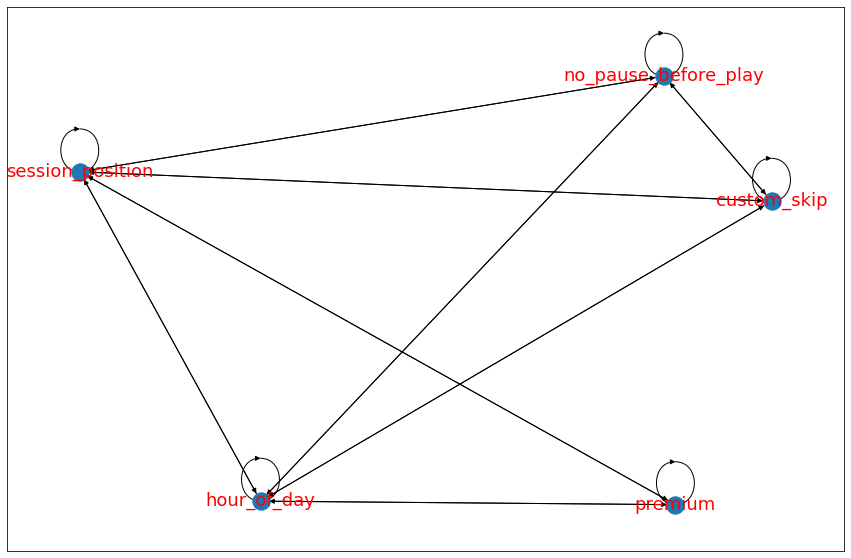

In [37]:
# apply graph lasso to data
skeleton = glasso.predict(df2)# visualize network
fig = plt.figure(figsize=(15,10))
nx.draw_networkx(skeleton, font_size=18, font_color='r')

In [46]:
# Use causal discovery to get causal models# PC algorithm
model_pc = cdt.causality.graph.PC()
graph_pc = model_pc.predict(df1, skeleton)


# visualize network
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(graph_pc, font_size=18, font_color='r')

PC is ran on the skeleton of the given graph.



R Python Error Output 
-----------------------

[Errno 2] No such file or directory: '/var/folders/md/5m2hbvy91mb1b69cyygvfmw40000gn/T/cdt_pc_3da421e7-8e68-4a6e-9a63-cbffd164cb7c/result.csv'


RuntimeError: RProcessError 
R Process Error Output 
-----------------------
Loading required package: momentchi2
Loading required package: MASS
Error in skeleton(suffStat, indepTest, alpha, labels = labels, method = skel.method,  : 
  Dimensions of the dataset and fixedGaps do not agree.
Calls: runPC -> <Anonymous> -> skeleton
Execution halted


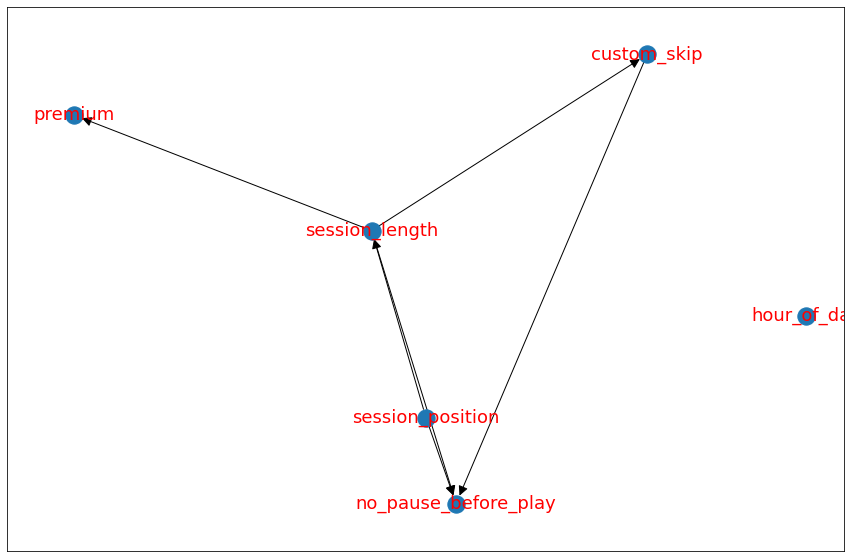

In [32]:
# Use causal discovery to get causal models# PC algorithm
model_lingam = cdt.causality.graph.LiNGAM()
graph_pc = model_lingam.predict(df1)

# visualize network
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(graph_pc, font_size=18, font_color='r', arrowsize=20)

In [33]:
df.columns

Index(['Unnamed: 0', 'session_id', 'session_position', 'session_length',
       'track_id_clean', 'skip_1', 'skip_2', 'skip_3', 'not_skipped',
       'context_switch', 'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'skip', 'custom_skip', 'pause_before_play', 'custom_pause_before_play'],
      dtype='object')

In [34]:
df.skip_1 = df.skip_1.astype(int)

In [35]:
df.premium = df.premium.astype(int)

In [36]:
from cdt.causality.graph import LiNGAM
obj = LiNGAM()
x = obj.predict(df)


R Python Error Output 
-----------------------

[Errno 2] No such file or directory: '/var/folders/md/5m2hbvy91mb1b69cyygvfmw40000gn/T/cdt_lingam_7a9b4bf2-88dd-4fbf-89eb-aeddf8458bc2/result.csv'


RuntimeError: RProcessError 
R Process Error Output 
-----------------------
Error in colMeans(x, na.rm = TRUE) : 'x' must be numeric
Calls: lingam ... estLiNGAM -> fastICA -> scale -> scale.default -> colMeans
Execution halted


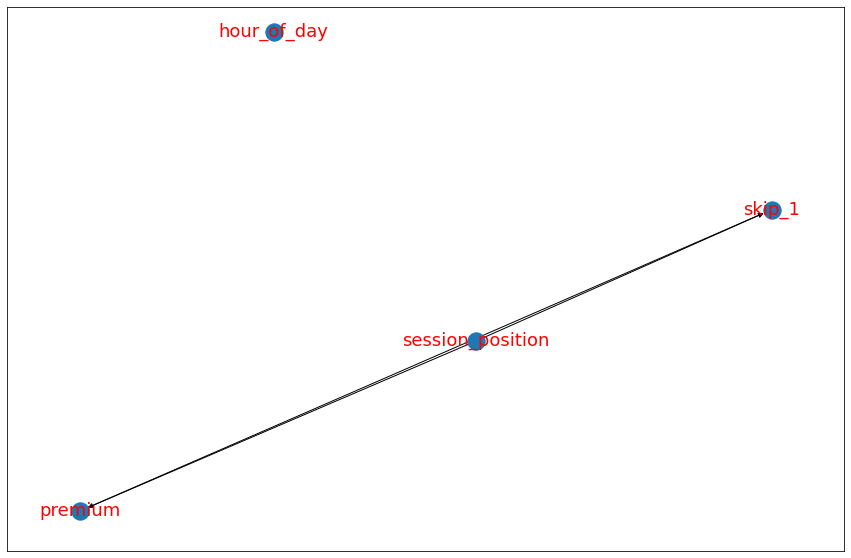

In [ ]:
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(x, font_size=18, font_color='r')